In [733]:
import torch
from torch.utils.data import DataLoader # loads data either in chunks or full
import torch.nn.functional as F
from torchvision import datasets # open datasets
from torchvision.transforms import ToTensor # transfor data to tensor
import matplotlib.pyplot as plt

In [734]:
# choosing gpu for training
device = ("cuda:0" if torch.cuda.is_available() else "cpu")
device

'cuda:0'

In [735]:
# download training and test data from open datasets.
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [736]:
# loading the data
train_dataloader = DataLoader(train_data, batch_size=64) # goes over 938 batches of 64
test_dataloader = DataLoader(test_data, batch_size=64)

Name: Sneaker, Number: 7


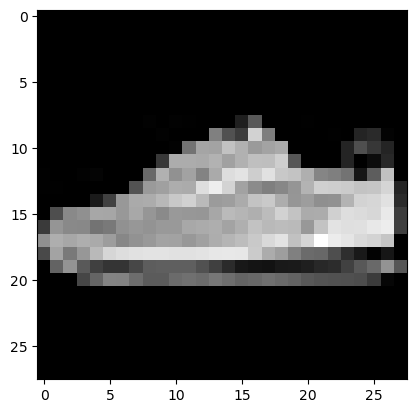

In [737]:
# plotting and understanding images and labels with first batch

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

images, labels = next(iter(train_dataloader))
idx = torch.randint(0, 64, (1,)).item()
image = images[idx].squeeze()
label = labels[idx]
print(f"Name: {labels_map[label.item()]}, Number: {label.item()}")
plt.imshow(image, cmap="grey")
plt.show()

In [738]:
# flattening the image from 2d to 1d
images = images.view(images.size(0), -1)
print(f"Input (images): {images.shape}\t Output (labels): {labels.shape}")


Input (images): torch.Size([64, 784])	 Output (labels): torch.Size([64])


In [739]:
# implementing MLP

class Neuron:
    # nin is number of inputs
    def __init__(self, nin):
        self.w = torch.rand(nin, requires_grad=True, device="cuda:0")
        self.b = torch.randn(1, requires_grad=True, device="cuda:0")
    
    # x is how many inputs
    def __call__(self, x):
        x = torch.as_tensor(x).clone().detach().requires_grad_(True).float() # clone tensor 
        act = torch.matmul(self.w, x) + self.b  # matrix multiplication with compatible shapes
        out = torch.tanh(act)
        return out # tensor of 1D with 1 value
    
    def parameters(self):
        return torch.cat([self.w, self.b]).requires_grad_()
    
class Layer:
    def __init__(self, nin, nout):
        # create nout neurons with nin inputs
        # the amount of neurons is based on how many outputs we need
        self.neurons = [Neuron(nin) for _ in range(nout)] # list of neurons
    
    # x is how many neurons
    def __call__(self, x):
        x = torch.as_tensor(x).cuda().clone().detach().requires_grad_(True).float()
        outs = [n(x) for n in self.neurons]
        # print(self.layers[0].parameters())
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    # nin is number of inputs
    # nouts is the list of number of outputs/neurons per each layer
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]
    
    # bruh this is forward propagation?? weird
    def __call__(self, x):
        x = torch.as_tensor(x).cuda().clone().detach().requires_grad_(True).float()
        for layer in self.layers:
            x = layer(x) # x is the input from the other neurons
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    

In [740]:
# implementing neuron
neuron = Neuron(784)
random_tensor = torch.randn(784, dtype=torch.float32, device=device)
neuron(random_tensor)

tensor([-1.0000], device='cuda:0', grad_fn=<TanhBackward0>)

In [741]:
# implementing layer
layer = Layer(784, 10)
layer(random_tensor)

[tensor([-1.], device='cuda:0', grad_fn=<TanhBackward0>),
 tensor([-1.], device='cuda:0', grad_fn=<TanhBackward0>),
 tensor([-1.], device='cuda:0', grad_fn=<TanhBackward0>),
 tensor([-1.], device='cuda:0', grad_fn=<TanhBackward0>),
 tensor([-1.], device='cuda:0', grad_fn=<TanhBackward0>),
 tensor([-1.], device='cuda:0', grad_fn=<TanhBackward0>),
 tensor([-1.], device='cuda:0', grad_fn=<TanhBackward0>),
 tensor([-1.], device='cuda:0', grad_fn=<TanhBackward0>),
 tensor([-0.9697], device='cuda:0', grad_fn=<TanhBackward0>),
 tensor([-0.9331], device='cuda:0', grad_fn=<TanhBackward0>)]

In [742]:
mlp = MLP(784, [16, 16, 1])
mlp(random_tensor)

tensor([-1.0000], device='cuda:0', grad_fn=<TanhBackward0>)

In [743]:
images, labels = images.to(device), labels.to(device)
labels = labels / 10

In [768]:
ypred = [mlp(img) for img in images]
# ypred
# stacked_tensor = torch.stack(ypred)
# stacked_tensor
# print(stacked_tensor)
# print(labels)

loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(labels, ypred)])
# # [print(l.requires_grad) for l in mlp.parameters()]

# # for l in mlp.parameters():
# #     if l.requires_grad is not True:
# #         print("boohoo")
# # Zero out gradients
for p in mlp.parameters():
    if p.grad is not None:
        p.grad.zero_()  # Zero out gradients for each parameter

# Backpropagation
ypred.backward(retain_graph=True)

# Update parameters using gradient descent
learning_rate = 0.5
with torch.no_grad():  # Disable gradient tracking for parameter update
    for p in mlp.parameters():
        if p.grad is not None:  # Check if gradient is not None
            p.data += learning_rate * p.grad # Update parameters using gradient descent

loss

C:\Users\Elene2004\AppData\Local\Temp\ipykernel_5620\2361245539.py:16: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\cb\pytorch_1000000000000\work\build\aten\src\ATen/core/TensorBody.h:494.)
  if p.grad is not None:


tensor([26.8493], device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
# i = 0
# for batch, (x, y) in enumerate(train_dataloader):
#     x = x.view(x.size(0), -1)

#     x, y = x.to(device), y.to(device)

#     for img in x:
#         # img.to(device)
#         # print(img.shape)
#         mlp(img)